In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files

uploaded = files.upload()

Saving orders_and_shipments_final_cleaned.csv to orders_and_shipments_final_cleaned.csv


In [3]:
df = pd.read_csv("orders_and_shipments_final_cleaned.csv")
df.head(5)

,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Mode,Shipment Days - Scheduled,Order Date,Shipment Date,Region
0,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,Central America,Mexico,Puerto Rico,Standard Class,4,2/21/2015,2/27/2015,Latin America
1,7:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,South America,Brazil,Puerto Rico,Standard Class,4,3/2/2015,3/6/2015,Latin America
2,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,LATAM,Central America,Mexico,Puerto Rico,Standard Class,4,4/18/2015,4/20/2015,Latin America
3,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,Europe,Northern Europe,Denmark,Puerto Rico,Standard Class,4,6/10/2015,6/12/2015,Europe
4,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,Europe,Northern Europe,Denmark,Puerto Rico,Standard Class,4,6/10/2015,6/12/2015,Europe


In [4]:

total_order_quantity = df["Order Quantity"].sum()
average_order_quantity = df["Order Quantity"].mean()

df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Shipment Date"] = pd.to_datetime(df["Shipment Date"])

df["Actual Shipment Days"] = (df["Shipment Date"] - df["Order Date"]).dt.days

average_lead_time = df["Actual Shipment Days"].mean()

df["On-Time Delivery"] = df["Actual Shipment Days"] <= df["Shipment Days - Scheduled"]
percentage_on_time_delivery = df["On-Time Delivery"].mean() * 100

print(f"Total Order Quantity: {total_order_quantity}")
print(f"Average Order Quantity: {average_order_quantity:.2f}")
print(f"Average Actual Shipment Duration (Lead Time): {average_lead_time:.2f} days")
print(f"Percentage of On-Time Deliveries: {percentage_on_time_delivery:.2f}%")

print(
    "\nNote: Total sales, average order value, profit margins, and inventory turnover\n"
    "cannot be accurately calculated without specific price and cost data,\n"
    "which is not available in the current DataFrame."
)



Total Order Quantity: 66367
Average Order Quantity: 2.15
Average Actual Shipment Duration (Lead Time): 3.56 days
Percentage of On-Time Deliveries: 56.46%

Note: Total sales, average order value, profit margins, and inventory turnover
cannot be accurately calculated without specific price and cost data,
which is not available in the current DataFrame.


In [5]:
print(df.columns)


Index(['Order Time', 'Order Quantity', 'Product Department',
       'Product Category', 'Product Name', 'Customer Market',
       'Customer Region', 'Customer Country', 'Warehouse Country',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Order Date',
       'Shipment Date', 'Region', 'Actual Shipment Days', 'On-Time Delivery'],
      dtype='object')


In [6]:
# --- Convert order and shipment dates to datetime ---
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Shipment Date'] = pd.to_datetime(df['Shipment Date'])

# --- Calculate actual shipment days ---
df['Actual Shipment Days'] = (df['Shipment Date'] - df['Order Date']).dt.days

# --- Calculate delay ---
df['delay'] = df['Actual Shipment Days'] - df['Shipment Days - Scheduled']

# --- Optional: check the first few rows ---
print(df[['Order Date', 'Shipment Date', 'Shipment Days - Scheduled',
          'Actual Shipment Days', 'delay']].head())


  Order Date Shipment Date  Shipment Days - Scheduled  Actual Shipment Days  \
0 2015-02-21    2015-02-27                          4                     6   
1 2015-03-02    2015-03-06                          4                     4   
2 2015-04-18    2015-04-20                          4                     2   
3 2015-06-10    2015-06-12                          4                     2   
4 2015-06-10    2015-06-12                          4                     2   

   delay  
0      2  
1      0  
2     -2  
3     -2  
4     -2  


In [7]:
region_delays = df.groupby('Region')['delay'].mean().sort_values(ascending=False)
print(region_delays)


Region
Oceania          10.186120
Latin America     7.580829
Asia              6.939369
Europe           -2.998844
North America    -6.589086
Africa           -8.053929
Middle East     -12.313208
Other           -13.864198
Name: delay, dtype: float64


In [8]:
route_delays = (
    df.groupby(['Warehouse Country', 'Customer Country'])['delay']
      .mean()
      .sort_values(ascending=False)
)

print(route_delays.head(10))


Warehouse Country  Customer Country
USA                Mauritania          147.400000
Puerto Rico        Peru                 89.886364
                   Guadalupe            69.000000
USA                Jamaica              61.750000
                   Gambia               56.600000
                   Barbados             53.785714
Puerto Rico        Venezuela            51.318182
                   Namibia              50.000000
                   Ireland              44.781250
                   Macedonia            43.000000
Name: delay, dtype: float64


In [9]:

# Step 1: Strip spaces and lowercase
df.columns = df.columns.str.strip().str.lower()

# Step 2: Replace hyphens with spaces
df.columns = df.columns.str.replace('-', ' ', regex=False)

# Step 3: Replace any sequence of spaces (2 or more) with a single underscore
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)

# Step 4: If there are still multiple underscores, reduce them to single underscore
df.columns = df.columns.str.replace(r'_+', '_', regex=True)

print("Cleaned columns:", df.columns.tolist())


Cleaned columns: ['order_time', 'order_quantity', 'product_department', 'product_category', 'product_name', 'customer_market', 'customer_region', 'customer_country', 'warehouse_country', 'shipment_mode', 'shipment_days_scheduled', 'order_date', 'shipment_date', 'region', 'actual_shipment_days', 'on_time_delivery', 'delay']


In [12]:
dept_delay = df.groupby('product_department')['delay'].mean().sort_values(ascending=False)
print(dept_delay)


product_department
Technology            7.912863
Footwear              6.217374
Fan Shop              1.300260
Apparel               0.079895
Golf                 -1.186913
Outdoors             -1.334369
Health and Beauty    -3.413793
Fitness              -7.391414
Book Shop           -13.125000
Discs Shop          -15.068182
Pet Shop            -21.746667
Name: delay, dtype: float64


In [14]:
category_delay = df.groupby('product_category')['delay'].mean().sort_values(ascending=False)
print(category_delay)

product_category
Strength Training       55.428571
Music                   50.428571
Fitness Accessories     30.150943
Accessories             13.570533
Cameras                  9.628272
Electronics              7.692308
Cardio Equipment         5.330594
Indoor/Outdoor Games     3.629684
Golf Balls               2.924444
Children's Clothing      2.666667
Men's Footwear           2.462516
Fishing                  2.175469
Consumer Electronics     1.360000
Water Sports             0.767485
Sporting Goods           0.739130
Toys                     0.712329
Boxing & MMA             0.407895
Women's Golf Clubs       0.037037
Basketball              -0.111111
As Seen on  TV!         -0.181818
Cleats                  -0.516054
Men's Clothing          -0.750000
Women's Apparel         -0.977913
Girls' Apparel          -1.110000
CDs                     -1.111111
Lacrosse                -1.200000
Hockey                  -1.258427
Shop By Sport           -1.588358
Camping & Hiking        -2.0889

In [16]:
top_products = df.groupby('product_name')['delay'].mean().sort_values(ascending=False).head(15)
print(top_products)

product_name
Yakima DoubleDown Ace Hitch Mount 4-Bike Rack    65.000000
Hirzl Men's Hybrid Golf Glove                    58.585366
Rock music                                       50.428571
Team Golf Pittsburgh Steelers Putter Grip        46.725806
Titleist Pro V1x High Numbers Personalized Go    33.264151
Under Armour Hustle Storm Medium Duffle Bag      30.150943
LIJA Women's Button Golf Dress                   26.250000
Team Golf Texas Longhorns Putter Grip            24.982456
Under Armour Women's Ignite PIP VI Slide         20.420000
Bridgestone e6 Straight Distance NFL Tennesse    18.810811
Clicgear 8.0 Shoe Brush                          18.404762
adidas Youth Germany Black/Red Away Match Soc    17.566038
Nike Women's Tempo Shorts                        15.843750
Under Armour Men's Compression EV SL Slide       15.000000
Bag Boy Beverage Holder                          12.979592
Name: delay, dtype: float64


In [18]:
market_delay = df.groupby('customer_market')['delay'].mean().sort_values(ascending=False)
print(market_delay)

customer_market
LATAM            7.580829
Pacific Asia     3.131422
Europe          -2.998377
North America   -6.589086
Africa          -9.068460
Name: delay, dtype: float64


In [19]:
region_delay = df.groupby('customer_region')['delay'].mean().sort_values(ascending=False).head(5)
print(region_delay)

customer_region
Southeast Asia     12.381345
Oceania             8.664548
Caribbean           8.507749
South America       7.652009
Central America     7.299122
Name: delay, dtype: float64


In [20]:
country_delay = df.groupby('customer_country')['delay'].mean().sort_values(ascending=False).head(5)
print(country_delay)

customer_country
Mauritania    147.400000
Gambia         56.600000
Namibia        50.000000
Macedonia      43.000000
Peru           39.966102
Name: delay, dtype: float64


In [21]:
warehouse_delay = df.groupby('warehouse_country')['delay'].mean().sort_values(ascending=False)
print(warehouse_delay)

warehouse_country
Puerto Rico    1.370473
USA           -0.063168
Name: delay, dtype: float64


In [22]:
shipmode_delay = df.groupby('shipment_mode')['delay'].mean().sort_values(ascending=False)
print(shipmode_delay)

shipment_mode
First Class       1.913562
Standard Class    1.422752
Second Class     -2.217290
Same Day         -3.251515
Name: delay, dtype: float64


In [23]:
global_region_delay = df.groupby('region')['delay'].mean().sort_values(ascending=False)
print(global_region_delay)

region
Oceania          10.186120
Latin America     7.580829
Asia              6.939369
Europe           -2.998844
North America    -6.589086
Africa           -8.053929
Middle East     -12.313208
Other           -13.864198
Name: delay, dtype: float64


In [104]:
# Clean column names (keep original words but remove hidden spaces)
df.columns = df.columns.str.strip()


In [105]:


sns.set(style="whitegrid", font_scale=1.0)


In [106]:
# Convert dates to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Shipment Date'] = pd.to_datetime(df['Shipment Date'])

# Calculate actual shipment duration
df['Actual Shipment Days'] = (df['Shipment Date'] - df['Order Date']).dt.days

# Calculate delay (raw, using original data)
df['Delay'] = df['Actual Shipment Days'] - df['Shipment Days - Scheduled']

print("Created columns:\n", df[['Order Date','Shipment Date','Shipment Days - Scheduled','Actual Shipment Days','Delay']].head())


Created columns:
   Order Date Shipment Date  Shipment Days - Scheduled  Actual Shipment Days  \
0 2015-02-21    2015-02-27                          4                     6   
1 2015-03-02    2015-03-06                          4                     4   
2 2015-04-18    2015-04-20                          4                     2   
3 2015-06-10    2015-06-12                          4                     2   
4 2015-06-10    2015-06-12                          4                     2   

   Delay  
0      2  
1      0  
2     -2  
3     -2  
4     -2  


In [107]:
delayed = df.dropna(subset=['Delay']).copy()

print("Total rows:", len(df))
print("Rows with delay:", len(delayed))
print(delayed['Delay'].describe())


Total rows: 30871
Rows with delay: 30871
count    30871.000000
mean         0.488258
std        131.185705
min       -979.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max        974.000000
Name: Delay, dtype: float64


#Helper functions (summary + plotting)

In [108]:
def delay_summary(df_group, col, top_n=None):
    summary = (
        df_group.groupby(col)['Delay']
        .agg(
            shipments='count',
            average_delay='mean',
            median_delay='median'
        )
        .sort_values('average_delay', ascending=False)
    )
    if top_n is not None:
        summary = summary.head(top_n)
    return summary


def plot_delay(summary, title, xlabel="Average Delay (days)", figsize=(10,6)):
    plt.figure(figsize=figsize)
    sns.barplot(
        x=summary['average_delay'],
        y=summary.index.astype(str),
        orient='h',
        palette='viridis'
    )
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("")
    plt.gca().invert_yaxis()  # biggest delays on top
    plt.tight_layout()
    plt.show()

    print("\n=== TABLE FOR:", title, "===")
    print(summary)
    print("\n" + "="*80)


# Viz 1: Delays by Product Department

📌 VISUALIZATION 1 — Delays by Product Department


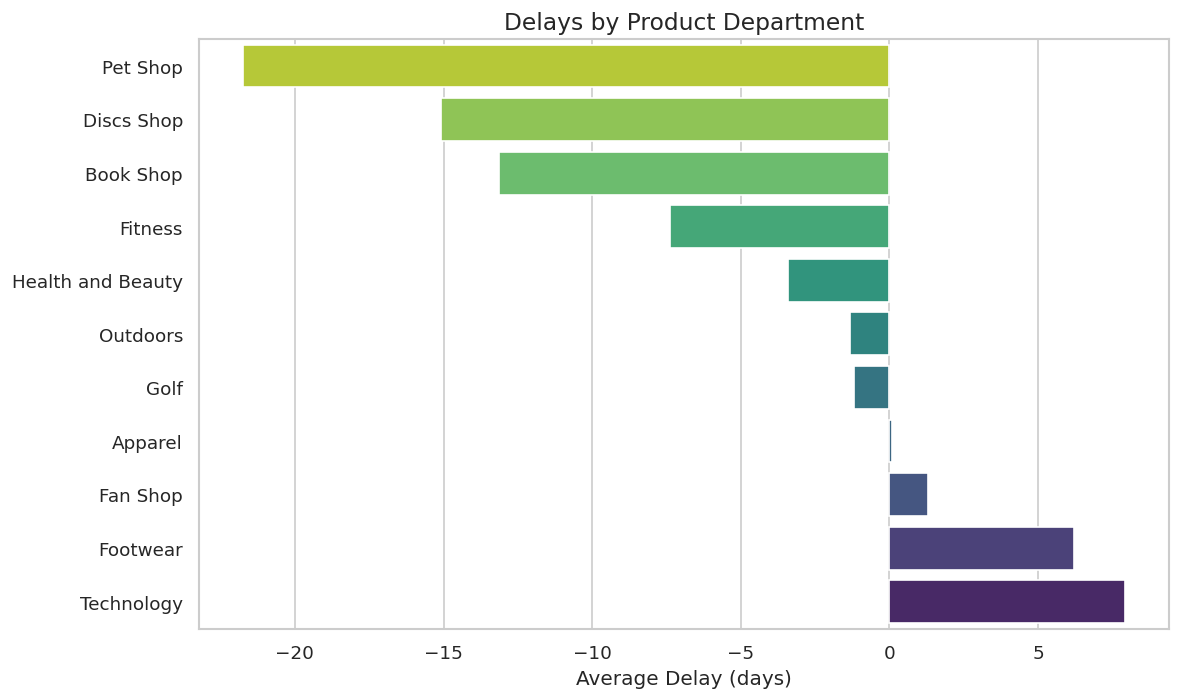


=== TABLE FOR: Delays by Product Department ===
                    shipments  average_delay  median_delay
Product Department                                        
Technology                241       7.912863           0.0
Footwear                 2544       6.217374           0.0
Fan Shop                11550       1.300260           0.0
Apparel                  8361       0.079895           0.0
Golf                     5746      -1.186913           0.0
Outdoors                 1609      -1.334369           0.0
Health and Beauty          29      -3.413793          -2.0
Fitness                   396      -7.391414           0.0
Book Shop                  56     -13.125000          -0.5
Discs Shop                264     -15.068182          -1.0
Pet Shop                   75     -21.746667          -1.0



In [109]:
print("📌 VISUALIZATION 1 — Delays by Product Department")
dept_summary = delay_summary(delayed, 'Product Department')
plot_delay(dept_summary, "Delays by Product Department")


# Viz 2: Delays by Product Category (Top 15)

📌 VISUALIZATION 2 — Top 20 Delayed Product Categories


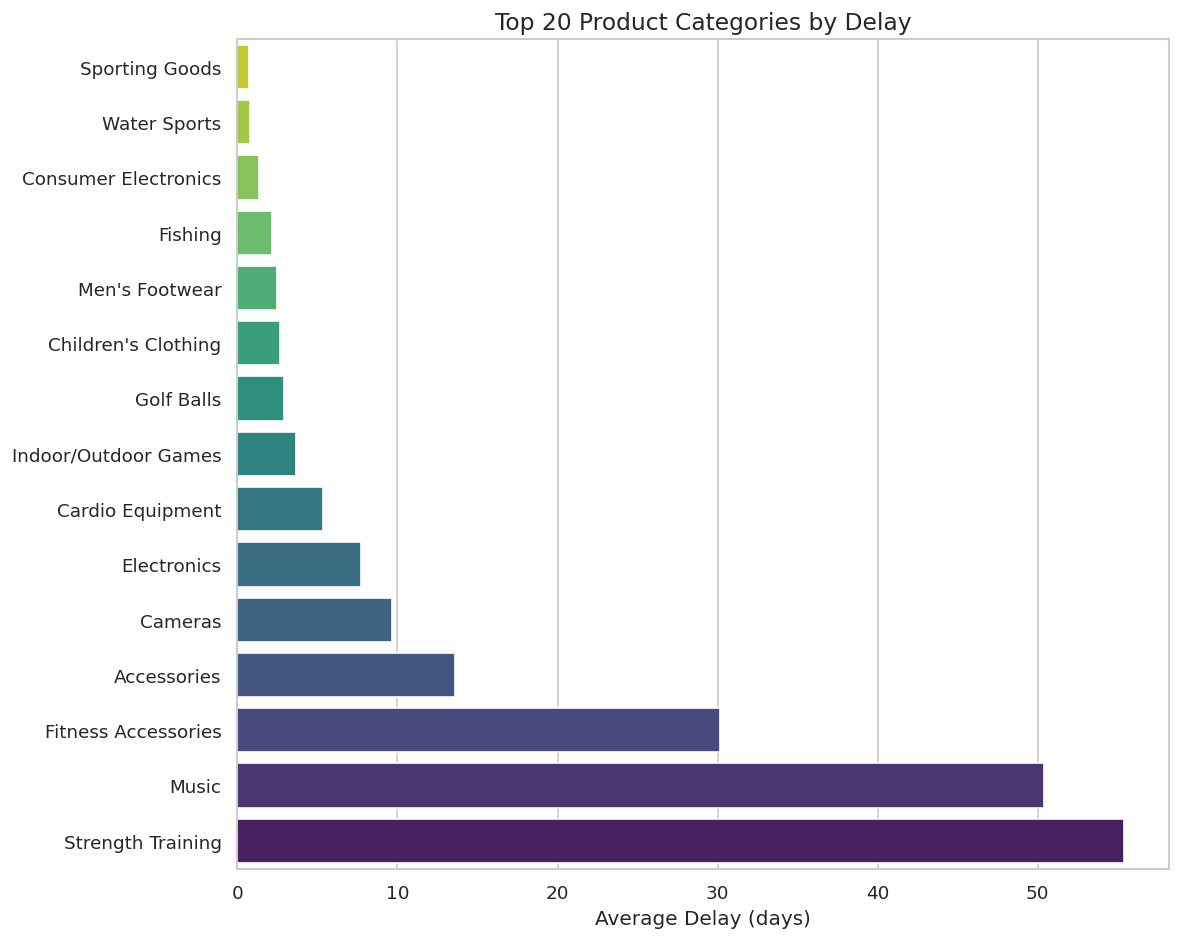


=== TABLE FOR: Top 20 Product Categories by Delay ===
                      shipments  average_delay  median_delay
Product Category                                            
Strength Training            14      55.428571          -0.5
Music                        14      50.428571          -2.0
Fitness Accessories          53      30.150943           1.0
Accessories                 319      13.570533           0.0
Cameras                     191       9.628272           0.0
Electronics                 520       7.692308           0.0
Cardio Equipment           2190       5.330594           0.0
Indoor/Outdoor Games       3416       3.629684           0.0
Golf Balls                  225       2.924444           0.0
Children's Clothing           9       2.666667           0.0
Men's Footwear             3855       2.462516           0.0
Fishing                    2878       2.175469           0.0
Consumer Electronics         50       1.360000          -2.0
Water Sports               268

In [111]:
print("📌 VISUALIZATION 2 — Top 20 Delayed Product Categories")
cat_summary = delay_summary(delayed, 'Product Category', top_n=15)
plot_delay(cat_summary, "Top 20 Product Categories by Delay", figsize=(10,8))


# Viz 3: Delays by Product Name (Top 15)

📌 VISUALIZATION 3 — Top 15 Delayed Products


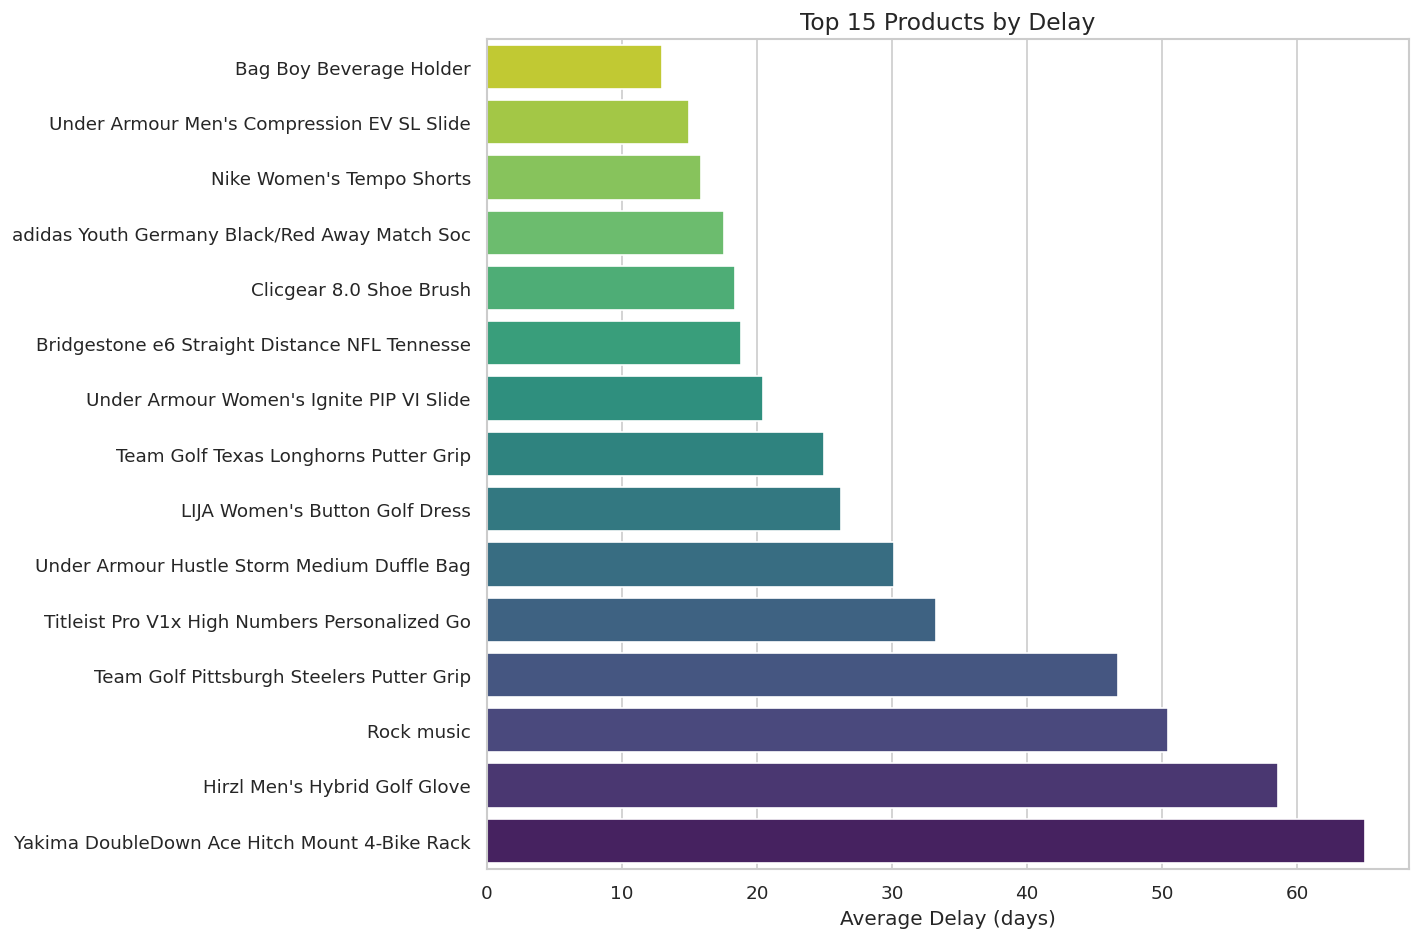


=== TABLE FOR: Top 15 Products by Delay ===
                                               shipments  average_delay  \
Product Name                                                              
Yakima DoubleDown Ace Hitch Mount 4-Bike Rack         12      65.000000   
Hirzl Men's Hybrid Golf Glove                         41      58.585366   
Rock music                                            14      50.428571   
Team Golf Pittsburgh Steelers Putter Grip             62      46.725806   
Titleist Pro V1x High Numbers Personalized Go         53      33.264151   
Under Armour Hustle Storm Medium Duffle Bag           53      30.150943   
LIJA Women's Button Golf Dress                        12      26.250000   
Team Golf Texas Longhorns Putter Grip                 57      24.982456   
Under Armour Women's Ignite PIP VI Slide              50      20.420000   
Bridgestone e6 Straight Distance NFL Tennesse         37      18.810811   
Clicgear 8.0 Shoe Brush                               4

In [112]:
print("📌 VISUALIZATION 3 — Top 15 Delayed Products")
prod_summary = delay_summary(delayed, 'Product Name', top_n=15)
plot_delay(prod_summary, "Top 15 Products by Delay", figsize=(12,8))


#Viz 4: Delays by Customer Market

📌 VISUALIZATION 4 — Delays by Customer Market


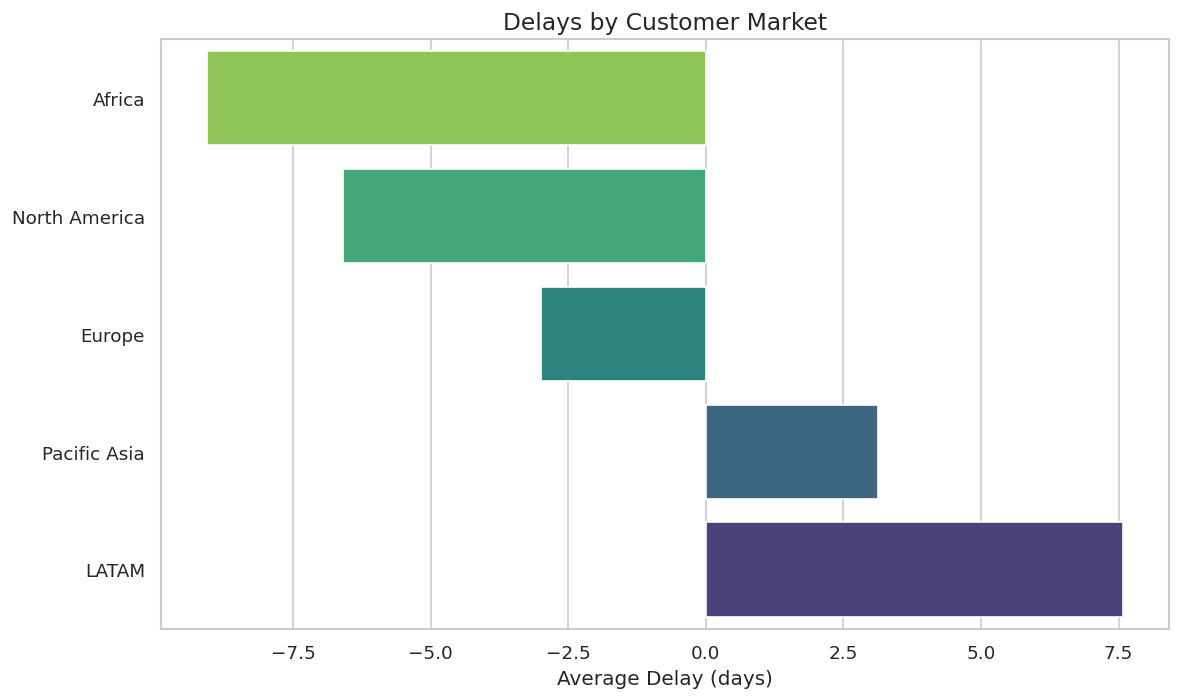


=== TABLE FOR: Delays by Customer Market ===
                 shipments  average_delay  median_delay
Customer Market                                        
LATAM                 9118       7.580829           0.0
Pacific Asia          6521       3.131422           0.0
Europe                8624      -2.998377           0.0
North America         4563      -6.589086           0.0
Africa                2045      -9.068460           0.0



In [113]:
print("📌 VISUALIZATION 4 — Delays by Customer Market")
market_summary = delay_summary(delayed, 'Customer Market')
plot_delay(market_summary, "Delays by Customer Market")


#Viz 5: Delays by Customer Region

📌 VISUALIZATION 5 — Delays by Customer Region


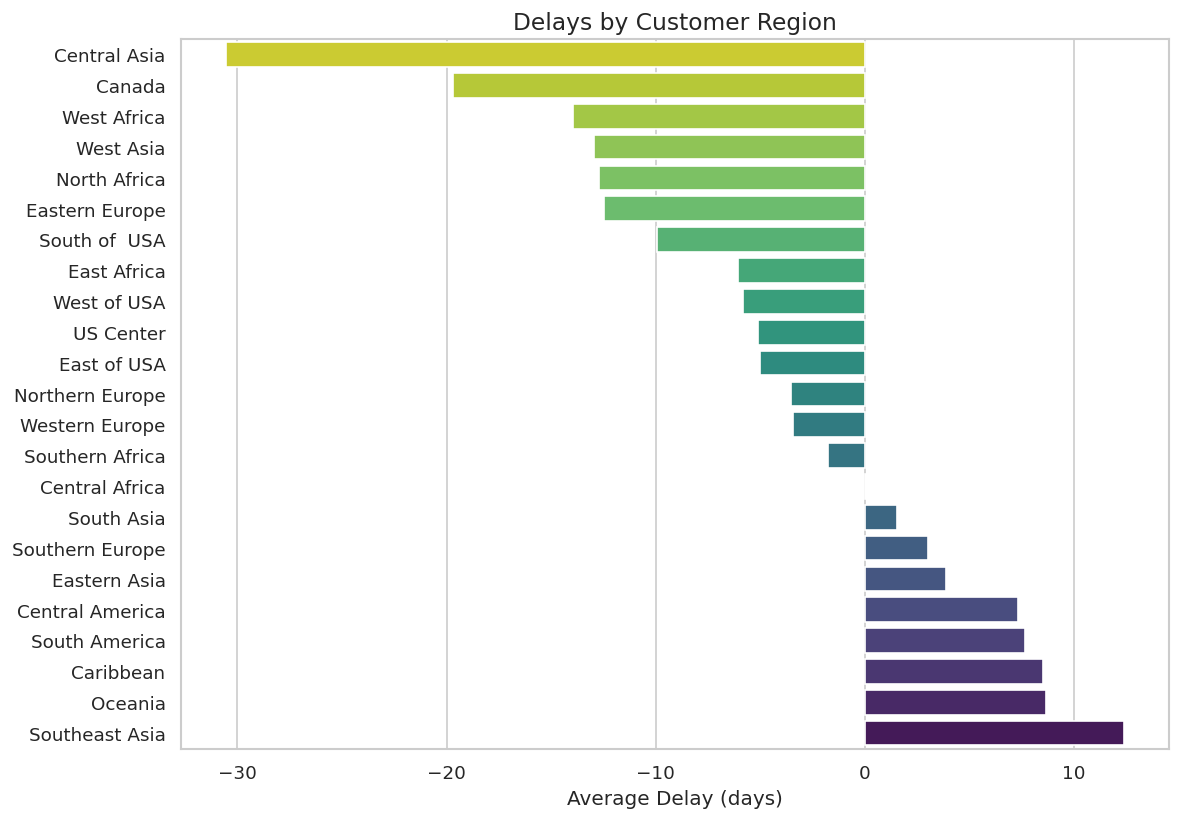


=== TABLE FOR: Delays by Customer Region ===
                 shipments  average_delay  median_delay
Customer Region                                        
Southeast Asia        1576      12.381345           0.0
Oceania               1416       8.664548           0.0
Caribbean             1355       8.507749           0.0
South America         2638       7.652009           0.0
Central America       5125       7.299122           0.0
Eastern Asia          1098       3.873406           0.0
Southern Europe       1559       3.017960           0.0
South Asia            1214       1.527183           0.0
Central Africa         267       0.059925           0.0
Southern Africa        286      -1.765734           0.0
Western Europe        4638      -3.457956           0.0
Northern Europe       1762      -3.531782           0.0
East of USA           1229      -4.995932           0.0
US Center             1111      -5.105311           0.0
West of USA           1332      -5.810811           0.0
Ea

In [114]:
print("📌 VISUALIZATION 5 — Delays by Customer Region")
region_summary = delay_summary(delayed, 'Customer Region')
plot_delay(region_summary, "Delays by Customer Region", figsize=(10,7))


#Viz 6: Delays by Customer Country (Top 15)

📌 VISUALIZATION 6 — Top 15 Delayed Countries


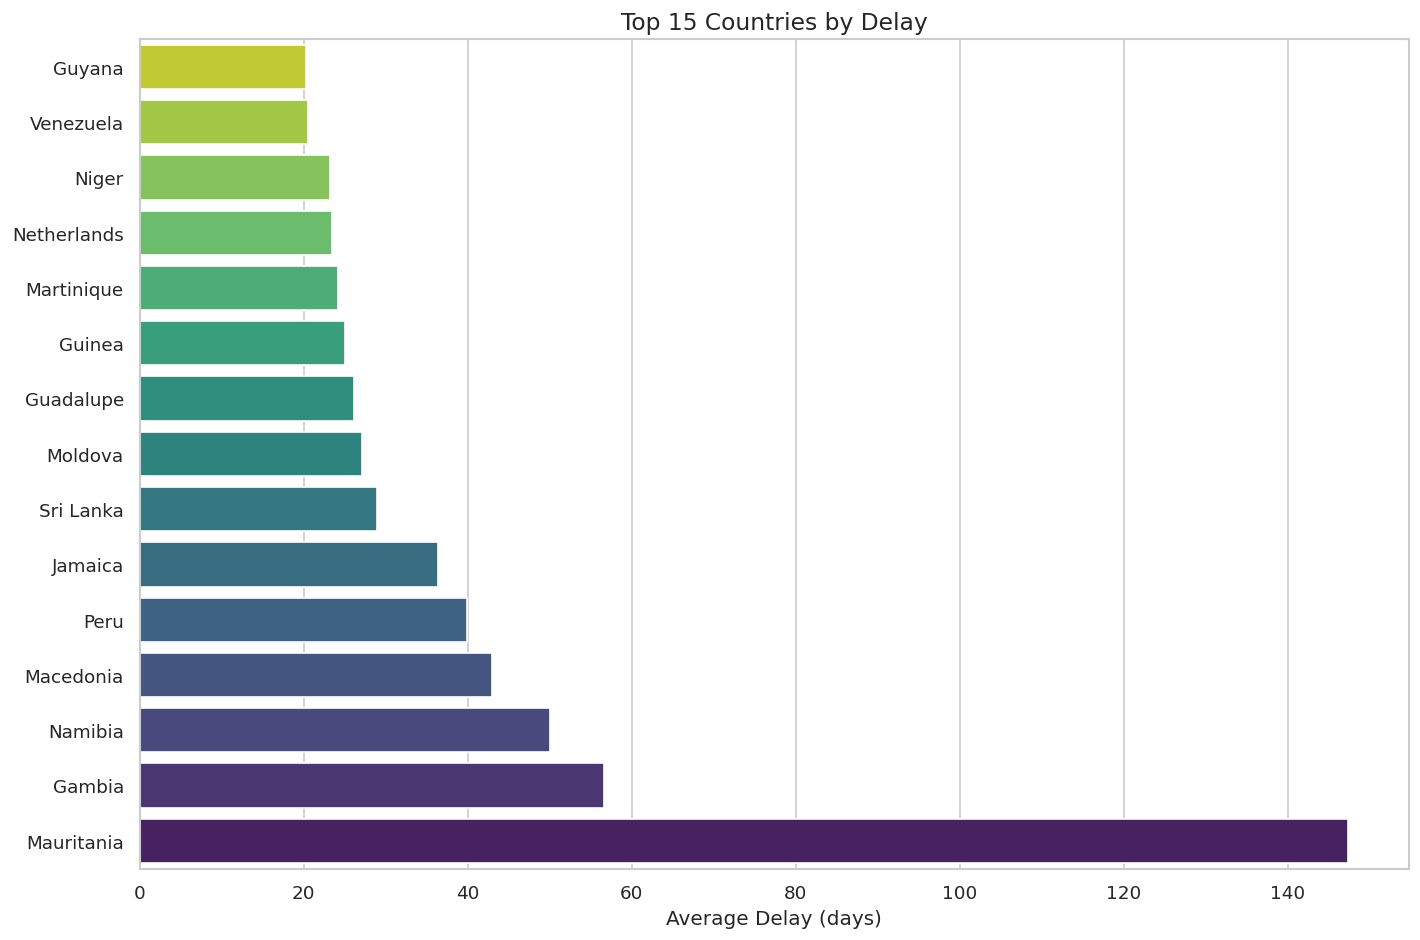


=== TABLE FOR: Top 15 Countries by Delay ===
                  shipments  average_delay  median_delay
Customer Country                                        
Mauritania                5     147.400000          -2.0
Gambia                    5      56.600000           2.0
Namibia                   3      50.000000           1.0
Macedonia                 1      43.000000          43.0
Peru                    118      39.966102           0.0
Jamaica                  39      36.410256           0.0
Sri Lanka                 2      29.000000          29.0
Moldova                   7      27.142857           3.0
Guadalupe                 8      26.125000           0.0
Guinea                   11      25.090909           0.0
Martinique                8      24.250000           0.0
Netherlands             273      23.487179           0.0
Niger                     6      23.166667           0.0
Venezuela               209      20.478469           0.0
Guyana                    3      20.333333

In [115]:
print("📌 VISUALIZATION 6 — Top 15 Delayed Countries")
country_summary = delay_summary(delayed, 'Customer Country', top_n=15)
plot_delay(country_summary, "Top 15 Countries by Delay", figsize=(12,8))


#Viz 7: Delays by Warehouse Country

📌 VISUALIZATION 7 — Delays by Warehouse Country


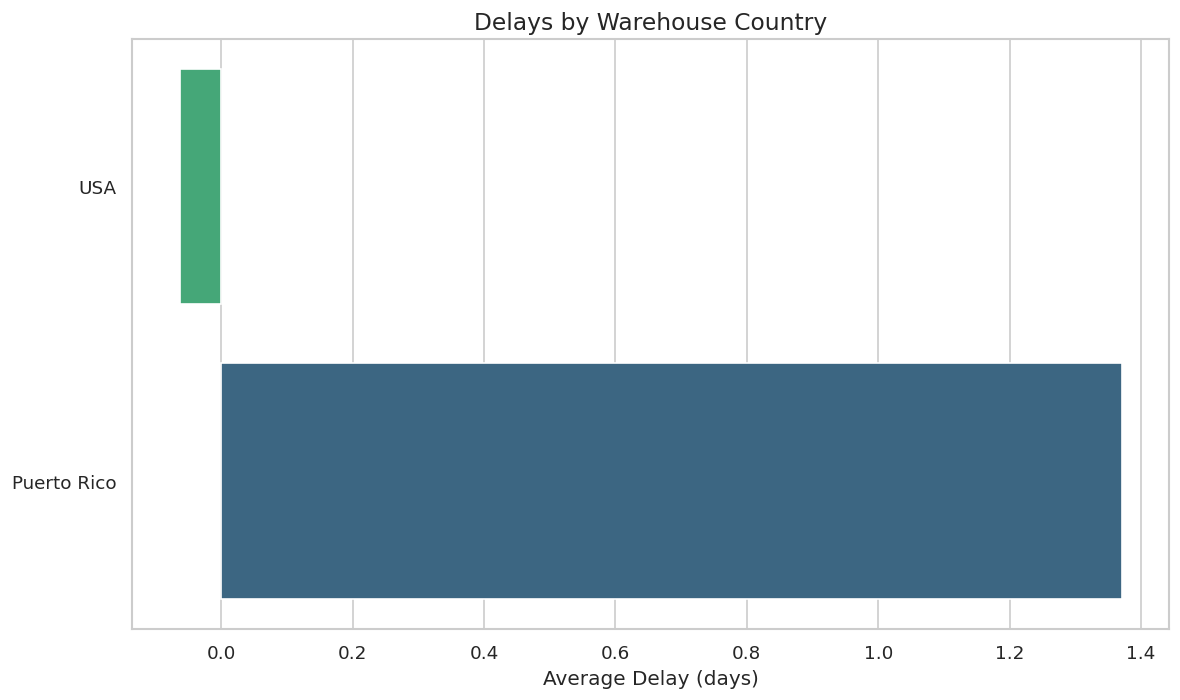


=== TABLE FOR: Delays by Warehouse Country ===
                   shipments  average_delay  median_delay
Warehouse Country                                        
Puerto Rico            11874       1.370473           0.0
USA                    18997      -0.063168           0.0



In [116]:
print("📌 VISUALIZATION 7 — Delays by Warehouse Country")
w_summary = delay_summary(delayed, 'Warehouse Country')
plot_delay(w_summary, "Delays by Warehouse Country")


#Viz 8: Delays by Shipment Mode

📌 VISUALIZATION 8 — Delays by Shipment Mode


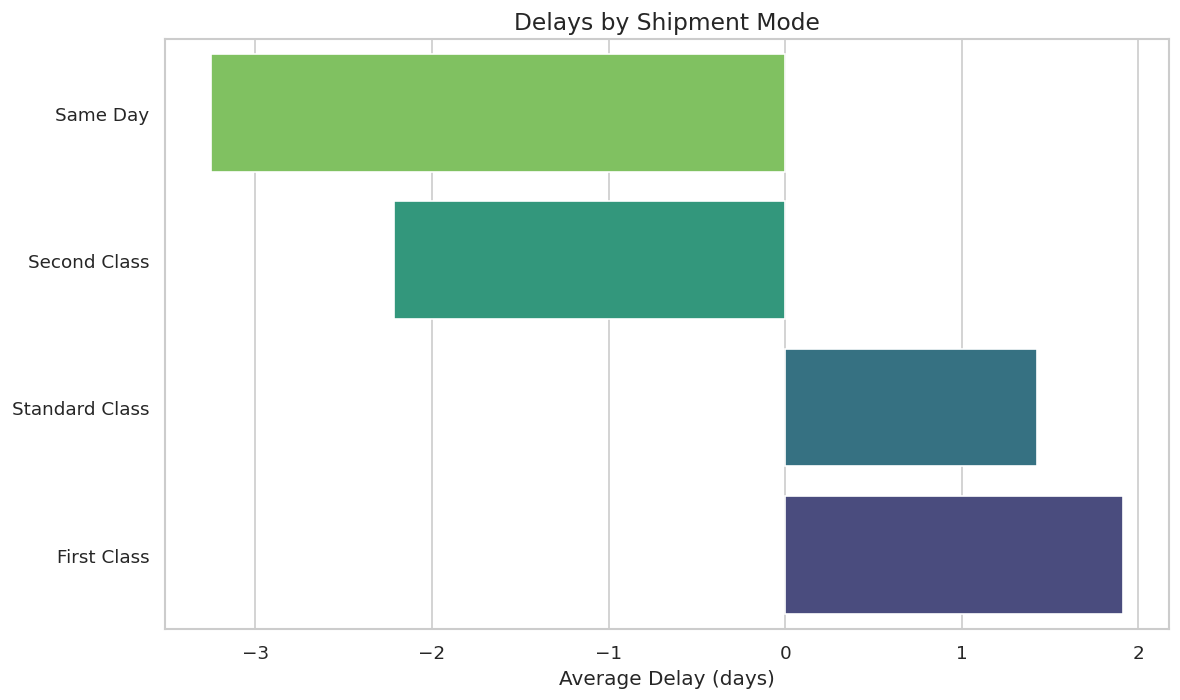


=== TABLE FOR: Delays by Shipment Mode ===
                shipments  average_delay  median_delay
Shipment Mode                                         
First Class          4859       1.913562           1.0
Standard Class      17994       1.422752           0.0
Second Class         6038      -2.217290           2.0
Same Day             1980      -3.251515          -2.0



In [117]:
print("📌 VISUALIZATION 8 — Delays by Shipment Mode")
mode_summary = delay_summary(delayed, 'Shipment Mode')
plot_delay(mode_summary, "Delays by Shipment Mode")


#Viz 9: Delays by Global Region (Region column)

📌 VISUALIZATION 9 — Delays by Global Region


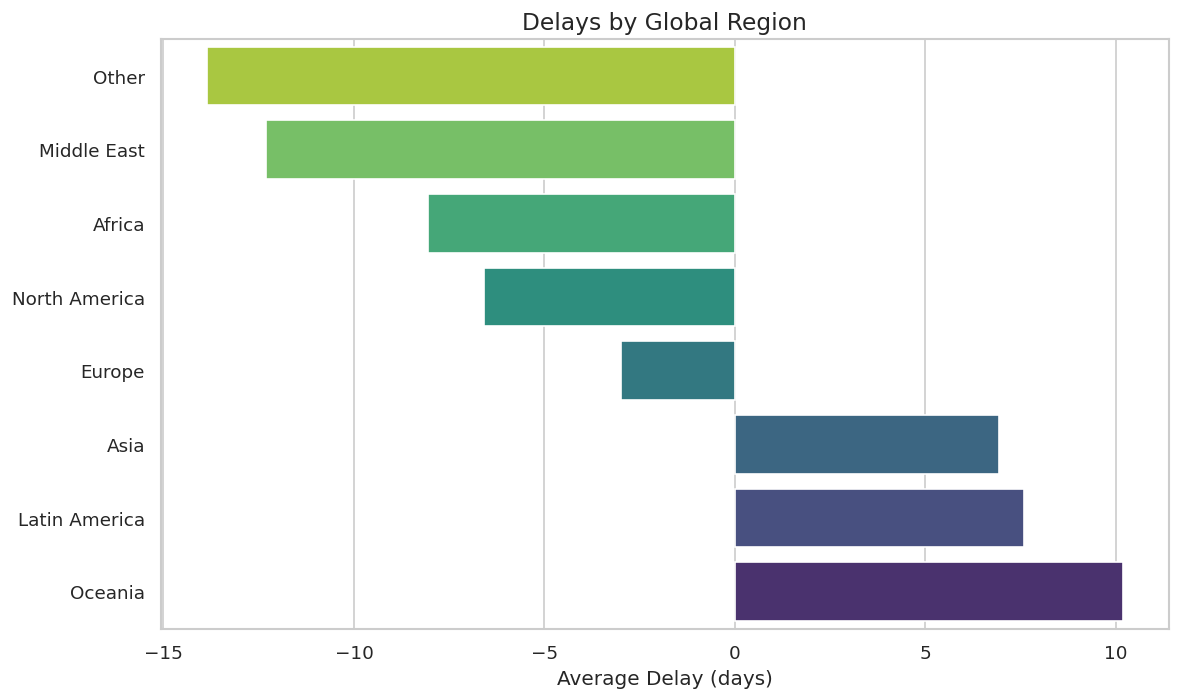


=== TABLE FOR: Delays by Global Region ===
               shipments  average_delay  median_delay
Region                                               
Oceania             1268      10.186120           0.0
Latin America       9118       7.580829           0.0
Asia                3678       6.939369           0.0
Europe              8648      -2.998844           0.0
North America       4563      -6.589086           0.0
Africa              1947      -8.053929           0.0
Middle East         1325     -12.313208           0.0
Other                324     -13.864198           0.0



In [118]:
print("📌 VISUALIZATION 9 — Delays by Global Region")
g_summary = delay_summary(delayed, 'Region')
plot_delay(g_summary, "Delays by Global Region")
